In [1]:
%reset -f

In [2]:
#Import libraries

import math as math
import cmath as cmath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.integrate import quad
from sklearn.linear_model import LinearRegression

In [5]:
# Question 1
# a) Heston Model

# Parameters

S0 = 100
x0 = math.log(S0)
r = 0.05
y = 0.02
v0 = 0.25
kappa = 0.2
theta = 0.2
lamda = 1
sigma = 0.3
rho = -0.2
T = 21/252
a = kappa * theta
u = [0.5, -0.5]
b = [kappa + lamda - rho * sigma, kappa + lamda]
strikes = [95, 100, 105]
df = np.exp(-(r - y) * T) # the discounted factor

In [7]:
# Compute the characteristic functions for the Heston model
def characteristic_func(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b, phi):

    d = [0.0, 0.0]
    g = [0.0, 0.0]
    C = [0.0, 0.0]
    D = [0.0, 0.0]
    edt = [0.0, 0.0]
    gedt = [0.0, 0.0]
    f = [0.0, 0.0]

    for j in range(2):
        temp = b[j] - 1j * rho * sigma * phi
        d[j] = cmath.sqrt(temp**2 - sigma**2 * (2.0 * u[j] * phi * 1j - phi**2))
        g[j] = (temp + d[j]) / (temp - d[j])

        edt[j] = cmath.exp(d[j] * T)
        gedt[j] = 1.0 - g[j] * edt[j]

        C[j] = (r - y) * phi * T * 1j + a / sigma**2 * ((temp + d[j]) * T - 2.0 * cmath.log(gedt[j] / (1.0 - g[j])))
        D[j] = (temp + d[j]) * (1.0 - edt[j]) / gedt[j] / sigma**2

        f[j] = cmath.exp(C[j] + D[j] * v0 + 1j * phi * x0)

    return f

In [9]:
# Compute probabilities P1 and P2 for the Heston model.
def probabilities(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b):

    ln_k = math.log(K)  # Compute the log of the strike price

    # Compute the integrand for P1 and P2
    def integrand(phi, index):
        f = characteristic_func(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b, phi)
        if index == 0:  # For P1
            temp = cmath.exp(-1j * phi * ln_k) * f[0] / (1j * phi)
        else:  # For P2
            temp = cmath.exp(-1j * phi * ln_k) * f[1] / (1j * phi)
        return temp.real

    # Use quad to compute the integrals
    pi_i = 1.0 / math.pi
    P1_integral, _ = quad(lambda phi: integrand(phi, 0), 0, math.inf)  # P1 integral
    P2_integral, _ = quad(lambda phi: integrand(phi, 1), 0, math.inf)  # P2 integral

    P1 = 0.5 + pi_i * P1_integral
    P2 = 0.5 + pi_i * P2_integral
    return [P1, P2]

In [11]:
# Compute the call price using probabilities from the Heston model
def call_price(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b):
    P = probabilities(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b)
    call_price = math.exp(-y * T) * S0 * P[0] - math.exp(-r * T) * K * P[1]
    return call_price

In [13]:
# Compute call prices for each strike
call_prices = [call_price(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b) for K in strikes]

# Print results
for K, price in zip(strikes, call_prices):
    print(f"Strike Price: {K}, European Call Price: {price}")

Strike Price: 95, European Call Price: 8.488870363620805
Strike Price: 100, European Call Price: 5.731201977112299
Strike Price: 105, European Call Price: 3.6711031477126355


In [15]:
# b) Monte Carlo Simulation

# Parameters
H = 90  # Barrier level
n_paths = 100000  # Number of Monte Carlo paths
n_steps = int(T * 252)  # Number of time steps
dt = 1 / 252  # Time step

In [17]:
# Seed for reproducibility
np.random.seed(42)

# Simulate Heston dynamics
def simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H):
    S = np.zeros((n_paths, n_steps + 1))  # Stock prices
    v = np.zeros((n_paths, n_steps + 1))  # Variances
    S[:, 0] = S0
    v[:, 0] = v0
    barrier_breached = np.zeros(n_paths, dtype=bool)  # Track barrier breach

    # Generate correlated Brownian motions
    Z1 = np.random.normal(size=(n_paths, n_steps))
    Z2 = np.random.normal(size=(n_paths, n_steps))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

    for t in range(1, n_steps + 1):
        v[:, t] = np.maximum((v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt +
                                sigma * np.sqrt(v[:, t - 1] * dt) * W2[:, t - 1]),0)
        S[:, t] = S[:, t - 1] * np.exp((r - y - 0.5 * v[:, t - 1]) * dt +
                                np.sqrt(v[:, t - 1] * dt) * W1[:, t - 1])
        barrier_breached = barrier_breached | (S[:, t] <= H)
    return S, barrier_breached

# Monte Carlo pricing of down-and-out call options
def monte_carlo_down_and_out(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H):
    S, barrier_breached = simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H)
    call_prices = []
    S_T = S[:, -1]  # Terminal stock prices

    for K in strikes:
        payoffs = np.where(~barrier_breached, np.maximum(S_T - K, 0), 0)
        y = np.mean(payoffs)
        price = df * np.mean(payoffs)
        variance = np.var(payoffs)  # Calculate variance of payoffs
        call_prices.append((price, variance))

    return call_prices

# Compute prices for given strikes
down_and_out_prices = monte_carlo_down_and_out(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H)

# Print results
for K, (price, variance) in zip(strikes, down_and_out_prices):
    print(f"Strike {K}: Down-and-Out Call Price = {price:.4f} and Variance = {variance:.4f}")


Strike 95: Down-and-Out Call Price = 8.0025 and Variance = 118.2137
Strike 100: Down-and-Out Call Price = 5.5731 and Variance = 83.7049
Strike 105: Down-and-Out Call Price = 3.6600 and Variance = 55.6318


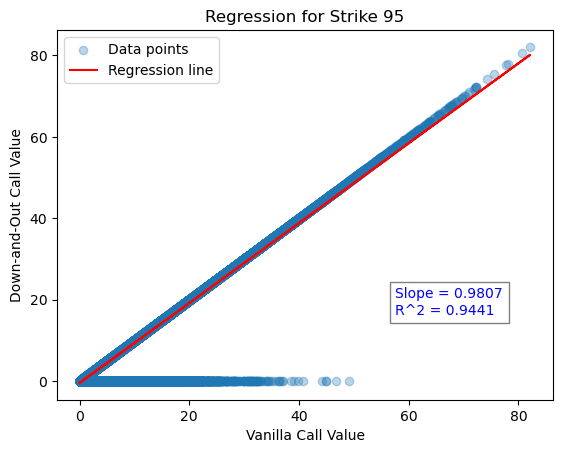

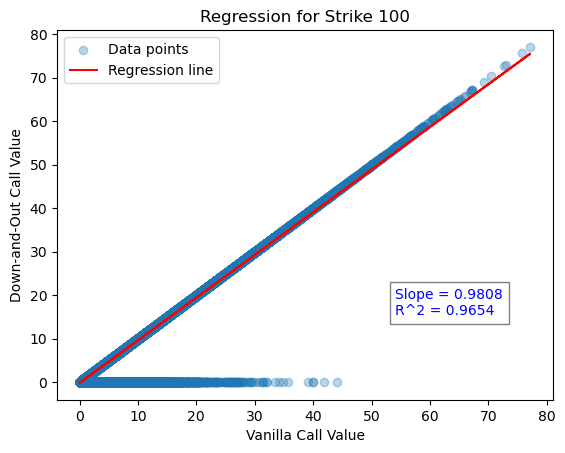

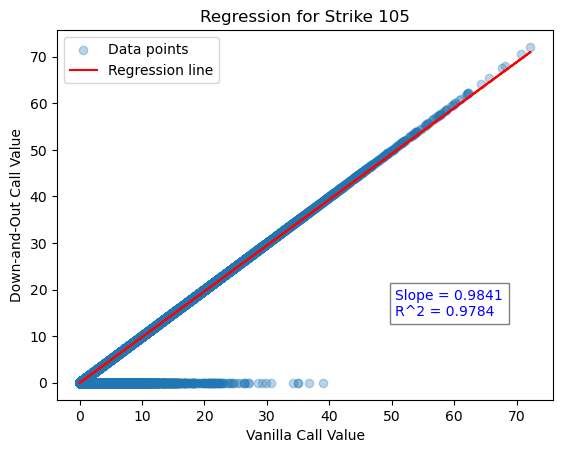

Strike 95: Adjusted Down-and-Out Call Price = 8.0105, Variance = 6.5712, Slope = 0.9807, R^2 = 0.9441
Strike 100: Adjusted Down-and-Out Call Price = 5.5829, Variance = 2.8859, Slope = 0.9808, R^2 = 0.9654
Strike 105: Adjusted Down-and-Out Call Price = 3.6699, Variance = 1.1969, Slope = 0.9841, R^2 = 0.9784


In [19]:
### 3) ------------------------

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Vanilla European call pricing using Monte Carlo
def monte_carlo_vanilla_call(S, K, r, T):
    S_T = S[:, -1]  # Terminal stock prices
    payoffs = np.maximum(S_T - K, 0)
    return df * payoffs

# Monte Carlo refinement with control variates
def control_variate_refinement(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H, n_batches):
    # Split paths into batches
    batch_size = n_paths // n_batches
    S, barrier_breached = simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H)

    # Store regression results
    adjusted_prices = []
    variances = []
    slopes = []
    r_squared = []
    
    # For each strike
    for K in strikes:
        down_and_out_values = []
        vanilla_call_values = []

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size

            # Batch data
            S_batch = S[start_idx:end_idx]
            barrier_breached_batch = barrier_breached[start_idx:end_idx]

            # Down-and-out payoffs
            down_and_out_payoffs = np.where(~barrier_breached_batch, np.maximum(S_batch[:, -1] - K, 0), 0)
            down_and_out_values.append(np.exp(-r * T) * down_and_out_payoffs)

            # Vanilla call payoffs
            vanilla_call_payoffs = monte_carlo_vanilla_call(S_batch, K, r, T)
            vanilla_call_values.append(vanilla_call_payoffs)

        # Combine all batches
        down_and_out_values = np.concatenate(down_and_out_values)
        vanilla_call_values = np.concatenate(vanilla_call_values)

        # Perform regression
        reg = LinearRegression()
        X = vanilla_call_values.reshape(-1, 1)
        Y = down_and_out_values
        reg.fit(X, Y)
        beta = reg.coef_[0]
        r2 = reg.score(X, Y)

        slopes.append(beta)
        r_squared.append(r2)
        
        adjusted_payoffs = Y - beta * (X.flatten() - np.mean(X))

        # Calculate adjusted price and variance
        adjusted_price = np.mean(adjusted_payoffs)
        variance = np.var(adjusted_payoffs)
        adjusted_prices.append(adjusted_price)
        variances.append(variance)

        # Plot data and regression line
        plt.scatter(X, Y, alpha=0.3, label="Data points")
        plt.plot(X, reg.predict(X), color='red', label="Regression line")
        plt.xlabel("Vanilla Call Value")
        plt.ylabel("Down-and-Out Call Value")
        plt.title(f"Regression for Strike {K}")
        plt.text(0.7 * max(X), 0.2 * max(Y),   
                 f"Slope = {beta:.4f}\nR^2 = {r2:.4f}", 
                 color="blue", fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5),
                 ha='left') 
        plt.legend()
        plt.show()

    return adjusted_prices, variances, slopes, r_squared

# Run control variate refinement
results = control_variate_refinement(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H, n_batches=40)

adjusted_prices, variances, slopes, r_squared = results

# Report results
for K, price, variance, slope, r2 in zip(strikes, adjusted_prices, variances, slopes, r_squared):
    print(f"Strike {K}: Adjusted Down-and-Out Call Price = {price:.4f}, Variance = {variance:.4f}, Slope = {slope:.4f}, R^2 = {r2:.4f}")

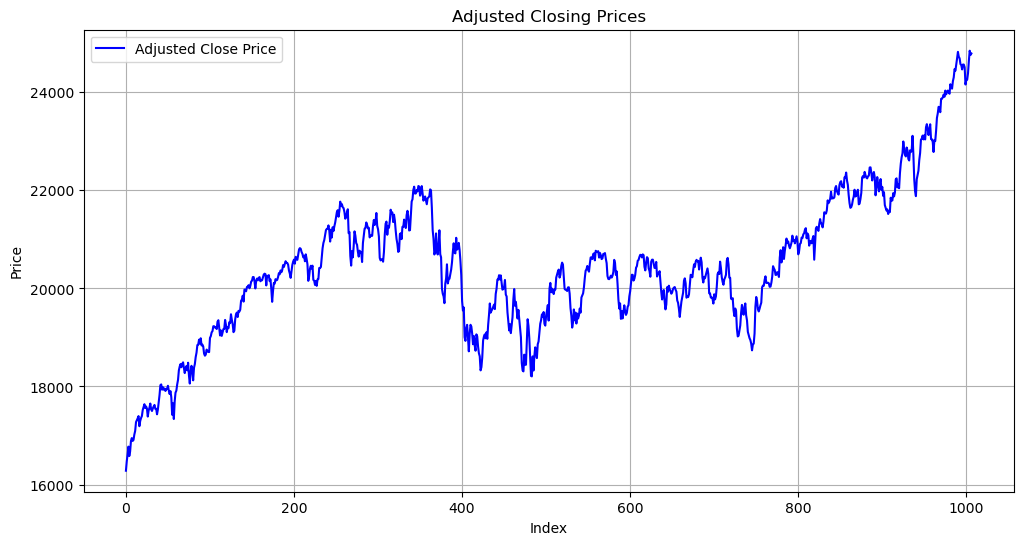

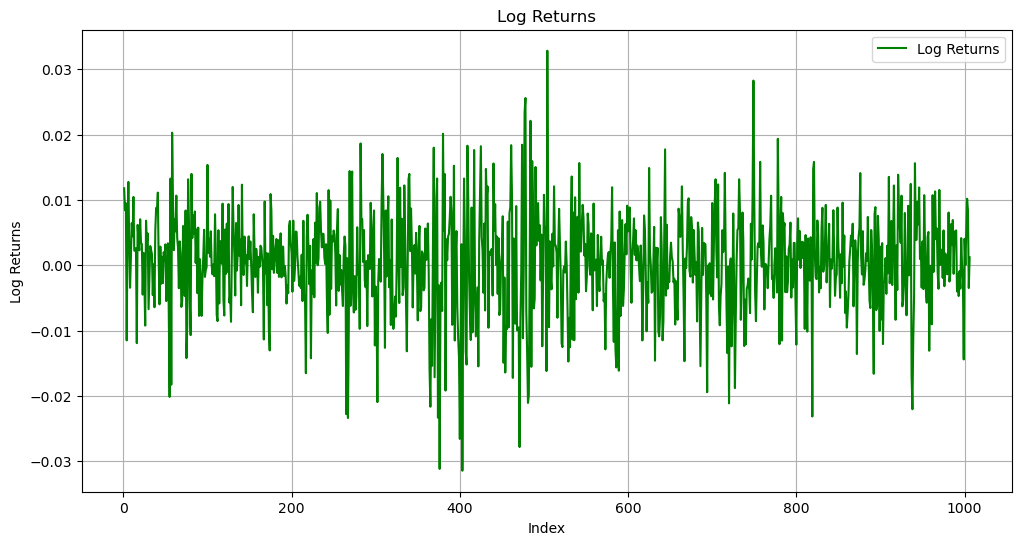

Sample Annualized Return Volatility: 12.37%


In [21]:
### ------------ PART TWO ------------
### 1)

# Load data

# Load the data
file_path = "dataTP2_A2024.csv"  # Replace with your file path
data = pd.read_csv(file_path, header=None)  # Assuming no headers in the CSV
prices = data.iloc[:, 0]  # First column with adjusted close prices

# Compute log daily returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Extract adjusted closing prices
closing_prices = data.iloc[:, 0]

# Plot the adjusted closing prices
plt.figure(figsize=(12, 6))
plt.plot(closing_prices, label='Adjusted Close Price', color='blue')
plt.title('Adjusted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plot the daily returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Log Returns', color='green')
plt.title('Log Returns')
plt.xlabel('Index')
plt.ylabel('Log Returns')
plt.legend()
plt.grid()
plt.show()

# Compute sample return volatility
annualized_volatility = log_returns.std() * np.sqrt(252)
print(f"Sample Annualized Return Volatility: {annualized_volatility:.2%}")

In [23]:
### 2) ------------------------------------

# Parameters
daily_rf_rate = 0.0275 / 365  # Daily risk-free rate
initial_variance = log_returns.iloc[0] ** 2  # Initialize h_0 with the square of the first return

# NGARCH(1,1) log-likelihood function
def ngarch_log_likelihood(params, returns):
    mu, omega, alpha, beta, gamma, lam = params

    # Initialize variance and arrays
    n = len(returns)
    h = np.zeros(n)
    h[0] = initial_variance
    z = np.zeros(n)

    log_likelihood = 0

    # Recursively compute variances and residuals
    epsilon = 1e-8  # Small value to prevent division by zero
    for t in range(1, n):
        # Update variance
        h[t] = omega + alpha * h[t - 1] * (z[t - 1] - gamma) ** 2 + beta * h[t - 1]
        if h[t] < 1e-8:  # Prevent non-positive variance
            h[t] = 1e-8
        elif h[t] > 1e6:  # Cap excessively large variances
            h[t] = 1e6

        # Update standardized residuals
        z[t] = (returns[t] - daily_rf_rate - lam * np.sqrt(h[t]) + 0.5 * h[t]) / (np.sqrt(h[t]) + epsilon)

        # Increment log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(h[t]) + z[t] ** 2)

    return -log_likelihood  # Negative for minimization


# Initial parameter guesses
initial_guess = [0.0, 0.1, 0.1, 0.8, 0.0, 0.1]  # [mu, omega, alpha, beta, gamma, lambda]
bounds = [
    (-np.inf, np.inf),  # mu can be any real number
    (1e-6, 1),  # omega > 0 and reasonably small
    (1e-6, 0.5),  # 0 < alpha < 0.5
    (1e-6, 0.9),  # 0 < beta < 0.9 (stationarity requires alpha + beta < 1)
    (-1, 1),  # -1 < gamma < 1
    (-5, 5),  # Reasonable bounds for lambda
]


# Optimization
result = minimize(
    ngarch_log_likelihood,
    initial_guess,
    args=(log_returns.values,),
    bounds=bounds,
    method="L-BFGS-B"
)

# Extract estimated parameters
mu, omega, alpha, beta, gamma, lam = result.x

# Compute implied unconditional volatility
unconditional_variance = omega / (1 - alpha * (1 + gamma ** 2) - beta)
unconditional_volatility = np.sqrt(unconditional_variance)

# Compare to sample volatility
sample_volatility = log_returns.std()

# Print results
print("Estimated Parameters:")
print(f"mu: {mu}")
print(f"omega: {omega}")
print(f"alpha: {alpha}")
print(f"beta: {beta}")
print(f"gamma: {gamma}")
print(f"lambda: {lam}")
print("\nUnconditional Volatility:")
print(f"Implied: {unconditional_volatility:.6f}")
print(f"Sample: {sample_volatility:.6f}")

Estimated Parameters:
mu: 0.0
omega: 6.196437995336548e-06
alpha: 0.12191021793182476
beta: 0.7715161990064875
gamma: -0.05266481163760151
lambda: 0.0977618373682354

Unconditional Volatility:
Implied: 0.007637
Sample: 0.007793


Strike Price | European Call Price
       23000 |          3259.639758
       23100 |          3163.990300
       23200 |          3068.855092
       23300 |          2974.300157
       23400 |          2880.376451
       23500 |          2787.119978
       23600 |          2694.604491
       23700 |          2602.880252
       23800 |          2511.984664
       23900 |          2422.030327
       24000 |          2333.117025
       24100 |          2245.295162
       24200 |          2158.649085
       24300 |          2073.285884
       24400 |          1989.293341
       24500 |          1906.688390
       24600 |          1825.588372
       24700 |          1746.070172
       24800 |          1668.217592
       24900 |          1592.124719
       25000 |          1517.754019
       25100 |          1445.184905
       25200 |          1374.528025
       25300 |          1305.884696
       25400 |          1239.265671
       25500 |          1174.721498
       25600 |          1112.

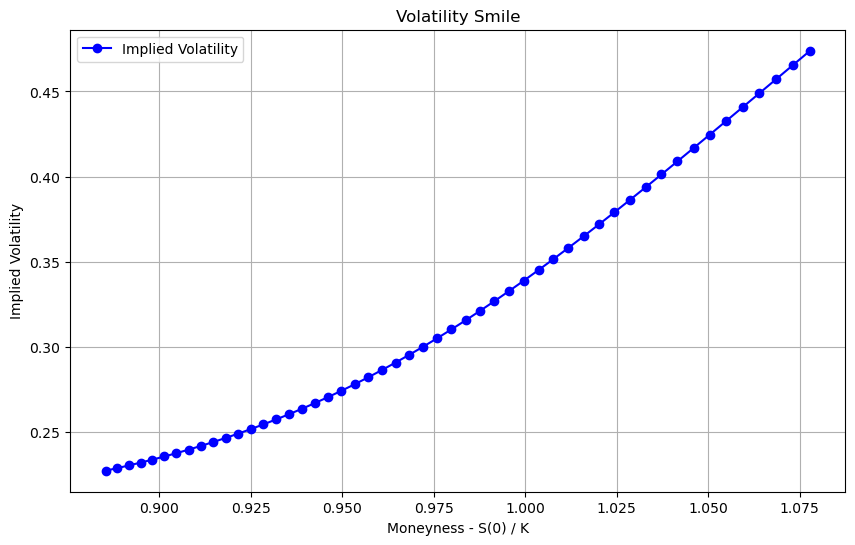

In [25]:
### 3) ------------------------------------
np.random.seed(777)  # For reproducibility

# Black-Scholes formula to calculate the European call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

# Function to calculate implied volatility using fsolve
def implied_volatility_call(S, K, T, r, market_price):
    # Objective function to minimize (difference between market price and Black-Scholes price)
    objective = lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price
    # Use fsolve to find the implied volatility
    implied_vol = fsolve(objective, 0.2)[0]  # Initial guess is 0.2
    return implied_vol

# Parameters
num_paths = 100000
num_days = 63
strikes = np.arange(23000, 28001, 100)  # Strike prices from 23,000 to 28,000
S_0 = data.iloc[-1, 0] # Set observed adjusted close as S_0

# Initialize arrays for simulation
simulated_prices = np.zeros((num_paths, num_days))
simulated_prices[:, 0] = S_0  # Start from the initial spot price

# Simulate paths
h_sim = np.full(num_paths, initial_variance)  # Initialize variance for all paths
z_sim = np.zeros(num_paths)  # Residuals for all paths

for t in range(1, num_days):
    # Simulate shocks (z_t)
    z_sim = np.random.normal(0, 1, num_paths)

    # Update variance using NGARCH(1,1) model
    h_sim = omega + alpha * h_sim * (z_sim - gamma)**2 + beta * h_sim
    h_sim = np.maximum(h_sim, 1e-8)  # Prevent non-positive variance

    # Update returns
    r_sim = daily_rf_rate + lam * np.sqrt(h_sim) - 0.5 * h_sim + np.sqrt(h_sim) * z_sim

    # Update prices
    simulated_prices[:, t] = simulated_prices[:, t-1] * np.exp(r_sim)

# Evaluate European Call Options at t = 0
discount_factor = np.exp(-daily_rf_rate * num_days)
call_prices_at_t0 = []

# Calculate call prices at t=0
for K in strikes:
    # Compute payoffs for all paths at t = T (at maturity)
    payoffs = np.maximum(simulated_prices[:, -1] - K, 0)

    # Discount and average to get option price at t = 0
    call_price_at_t0 = discount_factor * np.mean(payoffs)
    call_prices_at_t0.append(call_price_at_t0)

# Output results
print("Strike Price | European Call Price")
for strike, price in zip(strikes, call_prices_at_t0):
    print(f"{strike:12} | {price:20.6f}")

# Calculate moneyness S_0 / K for each strike price
moneyness = S_0 / strikes

# Calculate implied volatility for each strike using fsolve
implied_vols = []
for i in range(len(strikes)):
    K = strikes[i]
    market_price = call_prices_at_t0[i]

    # Calculate implied volatility
    implied_vol = implied_volatility_call(S_0, K, num_days / 252, daily_rf_rate, market_price)
    implied_vols.append(implied_vol)

# Plot the volatility smile based on moneyness
plt.figure(figsize=(10, 6))
plt.plot(moneyness, implied_vols, marker='o', color='blue', linestyle='-', label="Implied Volatility")

# Add labels and title
plt.title("Volatility Smile")
plt.xlabel("Moneyness - S(0) / K")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()